<a href="https://colab.research.google.com/github/sanjin94/HTool/blob/main/heat_transfer_pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import math
from scipy.sparse import diags
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

In [47]:
# Material class defines a dictionary conditioning an information
# on material characteristics of each element layer
class Material:
  def __init__(self):
    self.layers = []

  def new_material(self, material_name, cond, rho, c, l):
    my_dict = {'material' : material_name,
              'conductivity' : cond,
              'density' : rho,
              'capacity' : c,
              'layer_length' : l}
    self.layers.append(my_dict)

# Defining Resistance matrix and input vector needed for equation
# solution of system R * T = t, where R is resistance matrix, T is
# solution vector of temperatures (T = t / R) and t is input vector
class Resistance:
  def __init__(self, layers, delta_x, delta_t, Rsi=0.13, Rse=0.04):
    self.layers = layers
    self.R = []
    self.tau = []
    self.dx = delta_x
    self.delta_t = delta_t
    self.Rsi = Rsi
    self.Rse = Rse
    self.mat_list = []
    self.l = 0
    self.R_i = 0
    self.R_e = 0

  def resistance_tau(self):
    mesh = []
    mesh_cumulative = []
    help = 0
    eps = 1e-5
    diag_c = []
    diag_w = [0]
    diag_e = []
    for i in range(len(self.layers)):
      min = help
      max = help + self.layers[i]['layer_length']
      conductivity = self.layers[i]['conductivity']
      density = self.layers[i]['density']
      capacity = self.layers[i]['capacity']
      self.mat_list.append([min, max, conductivity, density, capacity])
      help = max

    self.l = max
    mat_list = np.copy(self.mat_list)
    
    help = 0
    for i in range(len(mat_list)):
      if self.dx > (mat_list[i][1] - mat_list[i][0]):
        delta_x = (mat_list[i][1] - mat_list[i][0])
      else:
        delta_x = self.dx
      
      min = mat_list[i][0]
      max = mat_list[i][1]
      material = mat_list[i][2]

      firstl = True
      lastl = True

      for j in range(math.ceil((max - min) / delta_x)):
        help += delta_x

        if (i == (len(mat_list) - 1)) and (abs(help - mat_list[i][1]) < eps) and lastl:
          dx = dx_h
          Rw = dx / 2 / mat_list[-1][2] + delta_x / 2 / mat_list[-1][2]
          Re = dx / 2 / mat_list[-1][2] + self.Rse
          self.R_e = Re
          Ci = mat_list[-1][3] * mat_list[-1][4] * dx / self.delta_t + 1 / Rw + 1 / Re
          diag_w.append(-1 / Rw)
          diag_c.append(Ci)
          self.tau.append(mat_list[-1][3] * mat_list[-1][4] * dx / self.delta_t)
          ## loop check
          #print('inside last 1')
          #print('help: ', help)
          #print('dx =', dx, 'delta_x = ', delta_x)
          ## mesh check
          #print(dx)
          mesh.append(dx)
          break
        elif (i == (len(mat_list) - 1)) and (help - mat_list[i][1] > 0) and lastl:
          dx = delta_x - (help - mat_list[i][1])
          Rw = dx / 2 / mat_list[-1][2] + delta_x / 2 / mat_list[-1][2]
          Re = dx / 2 / mat_list[-1][2] + self.Rse
          self.R_e = Re
          Ci = mat_list[-1][3] * mat_list[-1][4] * dx / self.delta_t + 1 / Rw + 1 / Re
          diag_w.append(-1 / Rw)
          diag_c.append(Ci)
          self.tau.append(mat_list[-1][3] * mat_list[-1][4] * dx / self.delta_t)
          ## loop check
          #print('inside last 2')
          #print('help: ', help)
          #print('dx =', dx, 'delta_x = ', delta_x)
          ## mesh check
          #print(dx)
          mesh.append(dx)
          break


        if help == delta_x:
          Rw = help / 2 / mat_list[0][2] + self.Rsi
          self.R_i = Rw
          Re = help / mat_list[0][2]
          Ci = mat_list[0][3] * mat_list[0][4] * help / self.delta_t + 1 / Rw + 1 / Re
          diag_c.append(Ci)
          diag_e.append(-1 / Re)
          self.tau.append(mat_list[0][3] * mat_list[0][4] * help / self.delta_t)
          ## loop check
          #print('!!inside first')
          #print('help: ', help)
          ## mesh check
          #print(delta_x)
          mesh.append(delta_x)
          dx_h = delta_x
          continue

        if (help >= mat_list[i][0]) and j == 0 and i > 0: 
          dx = dx_h
          Rw = dx / 2 / mat_list[i-1][2] + delta_x / 2 / mat_list[i][2]
          Re = delta_x / mat_list[i][2]
          Ci = mat_list[i][3] * mat_list[i][4] * delta_x / self.delta_t + 1 / Rw + 1 / Re
          diag_w.append(-1 / Rw)
          diag_c.append(Ci)
          diag_e.append(-1 / Re)
          self.tau.append(mat_list[i][3] * mat_list[i][4] * delta_x / self.delta_t)
          help = mat_list[i][0] + delta_x
          ## loop check
          #print('!!inside b1')
          #print('help: ', help)
          #print('dx =', dx, 'delta_x = ', delta_x)
          ## mesh check
          #print(delta_x)
          mesh.append(delta_x)
          continue
        
        if (i < (len(mat_list)-1)) and (abs(help - mat_list[i][1]) < eps) and lastl:
          dx = mat_list[i][1] - (help - delta_x)
          dx_h = dx
          Rw = dx / 2 / mat_list[i][2] + delta_x / 2 / mat_list[i][2]
          Re = dx / 2 / mat_list[i][2] + delta_x / 2 / mat_list[i+1][2]
          Ci = mat_list[i][3] * mat_list[i][4] * dx / self.delta_t + 1 / Re + 1 / Rw
          diag_w.append(-1 / Rw)
          diag_c.append(Ci)
          diag_e.append(-1 / Re)
          self.tau.append(mat_list[i][3] * mat_list[i][4] * dx / self.delta_t)
          lastl = False
          ## loop check
          #print('!!inside b21')
          #print('help: ', help)
          #print('dx =', dx)
          #print(help, mat_list[i][1])
          ## mesh check
          #print(dx)
          mesh.append(dx)
          continue
        elif (i < (len(mat_list)-1)) and (help - mat_list[i][1] > 0) and lastl:
          dx = mat_list[i][1] - (help - delta_x)
          dx_h = dx
          Rw = dx / 2 / mat_list[i][2] + delta_x / 2 / mat_list[i][2]
          Re = dx / 2 / mat_list[i][2] + delta_x / 2 / mat_list[i+1][2]
          Ci = mat_list[i][3] * mat_list[i][4] * dx / self.delta_t + 1 / Re + 1 / Rw
          diag_w.append(-1 / Rw)
          diag_c.append(Ci)
          diag_e.append(-1 / Re)
          self.tau.append(mat_list[i][3] * mat_list[i][4] * dx / self.delta_t)
          lastl = False
          ## loop check
          #print('!!inside b22')
          #print('help: ', help)
          #print(help, mat_list[i][1])
          ## mesh check
          #print(dx)
          mesh.append(dx)
          continue

        Re = delta_x / mat_list[i][2]
        Rw = Re
        Ci = mat_list[i][3] * mat_list[i][4] * delta_x / self.delta_t + 1 / Re + 1 / Rw
        diag_w.append(-1 / Rw)
        diag_c.append(Ci)
        diag_e.append(-1 / Re)
        self.tau.append(mat_list[i][3] * mat_list[i][4] * delta_x / self.delta_t)
        ## mesh check
        #print(delta_x)
        mesh.append(delta_x)
      
    #self.R = diags([diag_w, diag_c, diag_e], [-1, 0, 1]).toarray()
    diag_e.append(0)
    self.R = np.array([diag_w, diag_c, diag_e])
    self.tau = np.array(self.tau)
        
    return self.R, self.tau, [self.R_i, self.R_e], mesh

  def solve_he(self, R_mat, tau, R_bound, initial, indoor, outdoor):
    initial = np.array(initial)
    indoor = np.array(indoor)
    outdoor = np.array(outdoor)
    results = []
    end = len(indoor)
    perc = 0

    for i in range(end):
      initial_res = np.array(indoor[i])
      initial_res = np.append(initial_res, initial)
      initial_res = np.append(initial_res, outdoor[i])
      results.append(initial_res)
      tau2 = tau * initial
      tau2[0] = tau2[0] + indoor[i] / R_bound[0]
      tau2[-1] = tau2[-1] + outdoor[i] / R_bound[1]
      initial = linalg.solve_banded((1, 1), R_mat, tau2)

    return results

  def q_Q(self, temperatures, mesh):
    mat_list = np.copy(self.mat_list)
    
    q = []
    for i in range(len(temperatures)):
      R = mesh[0] / mat_list[0][2] + self.Rsi
      q.append((temperatures[i][1] - temperatures[i][0]) / R)
    q = np.array(q)
    Q = np.sum(q)

    return q, Q

class U_heat_flux:
  def __init__(self, layers, Rsi=0.13, Rse=0.04):
    self.layers = layers
    self.Rsi = Rsi
    self.Rse = Rse

  def uval(self):
    mat_list = []
    help = 0
    for i in range(len(self.layers)):
      min = help
      max = help + self.layers[i]['layer_length']
      conductivity = self.layers[i]['conductivity']
      mat_list.append([min, max, conductivity])

    R = self.Rsi

    for i in range(len(mat_list)):
      R += (mat_list[i][1] - mat_list[i][0]) / mat_list[i][2]

    R += self.Rse
    
    return 1 / R

  def q_U(self, U, indoor, outdoor):
    mat_list = []
    help = 0
    for i in range(len(self.layers)):
      min = help
      max = help + self.layers[i]['layer_length']
      conductivity = self.layers[i]['conductivity']
      mat_list.append([min, max, conductivity])

    results = []
    point = 0
    points = [-0.02, point]

    for i in range(len(mat_list)):
      point += mat_list[i][1]
      points.append(point)
    
    points.append(point + 0.02)

    for i in range(len(indoor)):
      q = - U * (indoor[i] - outdoor[i])

      ith_result = [indoor[i]]
      next = indoor[i] + q * self.Rsi
      ith_result.append(next)
      
      for j in range(len(mat_list)):
        Ri = (mat_list[j][1] - mat_list[j][0]) / mat_list[j][2]
        next += q * Ri
        ith_result.append(next)
     
      ith_result.append(outdoor[i])
    
      results.append(ith_result)

    return results, points

  def q_Q(self, U, indoor, outdoor):
    q = []
    for i in range(len(indoor)):
      q.append(- U * (indoor[i] - outdoor[i]))
    q = np.array(q)
    Q = np.sum(q)

    return q, Q


#### clases for extraction of vectors from HFM measurement (not necessary for app)
class RawData_index:

    def __init__(self, name, start, end):
        self.name = name
        self.start = start
        self.end = end

    # Initial dataframe to find indexes of first and last datapoint
    def dfinit(self):
        df = pd.read_csv(self.name, skiprows=1, on_bad_lines='skip', usecols=['TIMESTAMP'])
        #print(df)
        first = -1
        last = -1
        lt = len(self.start)

        df = df.to_numpy()
        for i in range(len(df)):
            if str(df[i][0])[0:lt] == self.start:
                first = i
            if str(df[i][0])[0:lt] == self.end:
                last = i

        if (first == -1) or (last == -1):
            print('ERROR! Timestamp does not work!')
            return

        return first, last

    # finding index of columns
    def cols(self):
        df = pd.read_csv(self.name, skiprows=1, low_memory=False)

        ti1 = df.columns.get_loc('T11')
        te1 = df.columns.get_loc('T21')
        ti2 = df.columns.get_loc('DT1temp')
        te2 = df.columns.get_loc('DT2temp')
        hf1 = df.columns.get_loc('HF1')
        hf2 = df.columns.get_loc('HF2')

        return [ti1, te1, ti2, te2, hf1, hf2]

# Extracting selected vectors from raw data file TRSYS01_Public.dat
class RawData_series:

    def __init__(self, name, f_ind, l_ind, columns):
        self.name = name
        self.f_ind = f_ind
        self.l_ind = l_ind
        self.columns = columns

    # Extracting function and averaging for every "ts_avg" minutes
    def ex_vect(self):

        first = self.f_ind + 2
        num_rows = self.l_ind - self.f_ind

        x_val = []

        for i in range(num_rows):
            x_val.append(i)

        x_val = np.array(x_val)

        df = pd.read_csv(self.name, usecols=self.columns, skiprows=first,
                        nrows=num_rows, header=None)

        for col in range(len(self.columns)):
            globals()[f"c{col}"] = df.iloc[:,col].to_numpy()

        return [c0, c1, c2, c3, c4*(-1), c5*(-1), x_val]

In [48]:
test_materijal = Material()
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_otpor = Resistance(test_materijal.layers, delta_x=0.005, delta_t=60)
R_mat, tau, R_bound, mesh = test_otpor.resistance_tau()

In [49]:
#from google.colab import files
#uploaded = files.upload()
!ls

heat_transfer_pilot.ipynb  TRSYS01_Public-beton.dat


In [50]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2021-12-23 16:00', '2021-12-29 09:00')
first, last = index.dfinit()
columns = index.cols()

In [51]:
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()

In [52]:
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]

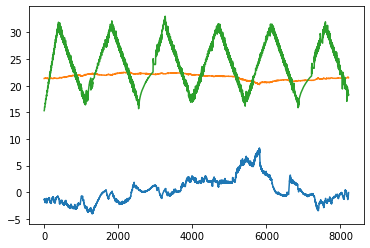

In [53]:
plt.plot(hf)
plt.plot(indoor)
plt.plot(outdoor)

In [54]:
outdoor_init = np.array([15 for i in range(60*60*3)])
indoor_init = np.array([21 for i in range(60*60*3)])
initial = np.array([18 for i in range(len(tau))])

In [55]:
res_init = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor_init, outdoor_init)

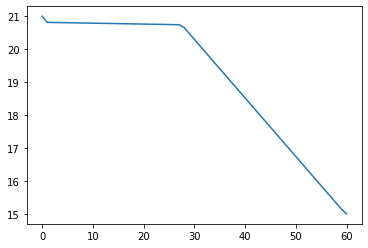

In [56]:
plt.plot(res_init[-1])

In [57]:
initial = res_init[-1][1:len(res_init[-1])-1]
results = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor, outdoor)

In [58]:
q_calc, Q = test_otpor.q_Q(results, mesh)

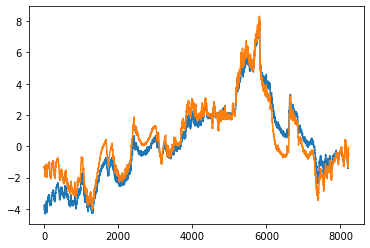

In [59]:
plt.plot(q_calc)
plt.plot(hf)

In [60]:
mse = metrics.mean_squared_error(hf, q_calc)
mae = metrics.mean_absolute_error(hf, q_calc)
r2 = metrics.r2_score(hf, q_calc)
print(f'mse: {mse}, mae: {mae}, Rsquared: {r2}')

mse: 0.6434433797925032, mae: 0.6541556114744008, Rsquared: 0.8786121647789077


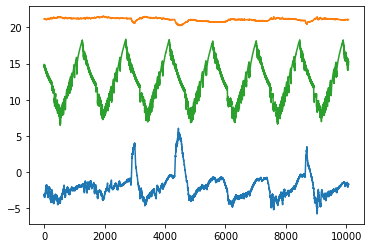

In [61]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2021-12-15 06:00', '2021-12-22 06:00')
first, last = index.dfinit()
columns = index.cols()
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]
plt.plot(hf)
plt.plot(indoor)
plt.plot(outdoor)

In [62]:
outdoor_init = np.array([15 for i in range(60*60*3)])
indoor_init = np.array([21 for i in range(60*60*3)])
initial = np.array([18 for i in range(len(tau))])
res_init = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor_init, outdoor_init)

In [63]:
initial = res_init[-1][1:len(res_init[-1])-1]
results = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor, outdoor)

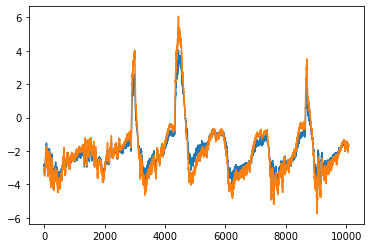

In [64]:
q_calc, Q_calc = test_otpor.q_Q(results, mesh)
plt.plot(q_calc)
plt.plot(hf)

In [65]:
mse = metrics.mean_squared_error(hf, q_calc)
mae = metrics.mean_absolute_error(hf, q_calc)
r2 = metrics.r2_score(hf, q_calc)
print(f'mse: {mse}, mae: {mae}, Rsquared: {r2}')

mse: 0.2114068414881943, mae: 0.3500564684797258, Rsquared: 0.9211878860860772


In [66]:
test_materijal = Material()
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
U_cls = U_heat_flux(test_materijal.layers)
U_val = U_cls.uval()
q_U, Q_U = U_cls.q_Q(U_val, indoor, outdoor)

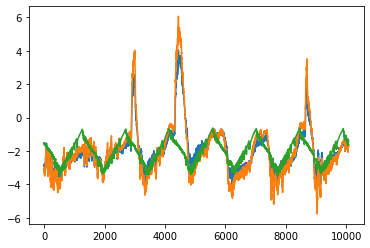

In [67]:
plt.plot(q_calc)
plt.plot(hf)
plt.plot(q_U)

In [68]:
Q_test = np.sum(hf)
print(Q_test, Q_U, Q_calc)

-20211.560370285002 -20047.135386626578 -20148.405323967636


In [69]:
test_materijal = Material()
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_otpor = Resistance(test_materijal.layers, delta_x=0.005, delta_t=60)
R_mat, tau, R_bound, mesh = test_otpor.resistance_tau()

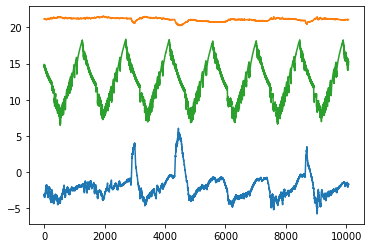

In [70]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2021-12-15 06:00', '2021-12-22 06:00')
first, last = index.dfinit()
columns = index.cols()
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]
plt.plot(hf)
plt.plot(indoor)
plt.plot(outdoor)

In [71]:
outdoor_init = np.array([15 for i in range(60*60*3)])
indoor_init = np.array([21 for i in range(60*60*3)])
initial = np.array([18 for i in range(len(tau))])
res_init = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor_init, outdoor_init)

In [72]:
initial = res_init[-1][1:len(res_init[-1])-1]
results_obrnuto = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor, outdoor)

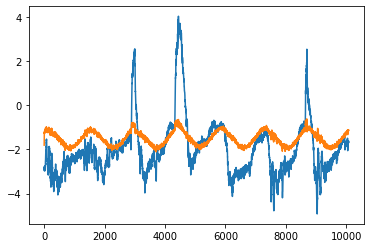

In [73]:
q_calc_obrnuto, Q_calc_obrnuto = test_otpor.q_Q(results_obrnuto, mesh)
plt.plot(q_calc)
plt.plot(q_calc_obrnuto)

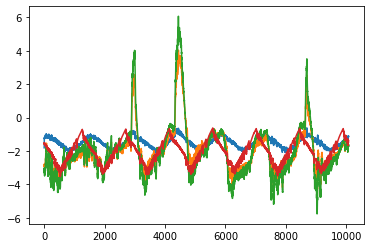

In [74]:
plt.plot(q_calc_obrnuto)
plt.plot(q_calc)
plt.plot(hf)
plt.plot(q_U)

In [75]:
Q_test = np.sum(hf)
print(Q_test, Q_U, Q_calc, Q_calc_obrnuto)

-20211.560370285002 -20047.135386626578 -20148.405323967636 -15131.994275768448


In [76]:
test_materijal = Material()
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
#test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
#test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_otpor = Resistance(test_materijal.layers, delta_x=0.005, delta_t=60)
R_mat, tau, R_bound, mesh = test_otpor.resistance_tau()

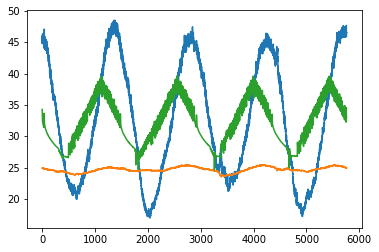

In [77]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2022-01-29 06:00', '2022-02-02 06:00')
first, last = index.dfinit()
columns = index.cols()
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]
plt.plot(hf)
plt.plot(indoor)
plt.plot(outdoor)

In [78]:
outdoor_init = np.array([15 for i in range(60*60*3)])
indoor_init = np.array([21 for i in range(60*60*3)])
initial = np.array([18 for i in range(len(tau))])
res_init = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor_init, outdoor_init)

In [79]:
initial = res_init[-1][1:len(res_init[-1])-1]
results_beton = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor, outdoor)

In [80]:
q_calc_beton, Q_calc_beton = test_otpor.q_Q(results_beton, mesh)

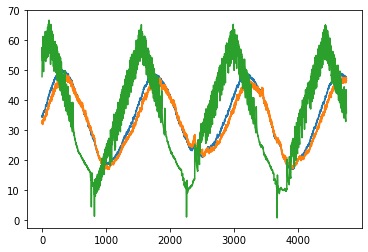

In [81]:
test_materijal = Material()
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
U_cls = U_heat_flux(test_materijal.layers)
U_val = U_cls.uval()
q_U_beton, Q_U_beton = U_cls.q_Q(U_val, indoor, outdoor)

plt.plot(q_calc_beton[1000:])
plt.plot(hf[1000:])
plt.plot(q_U_beton[1000:])

In [82]:
Q_test = np.sum(hf[1000:])
Q_U = np.sum(q_U_beton[1000:])
Q_calc_beton = np.sum(q_calc_beton[1000:])
print(Q_test, Q_U, Q_calc_beton)

158497.75901 169271.01489774694 165283.91433759965


In [83]:
### U vrijednost test

In [84]:
test_materijal = Material()
test_materijal.new_material('beton', cond=2.6, rho=2400, c=1000, l=0.135)
test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
U_cls = U_heat_flux(test_materijal.layers)

In [85]:
U_val = U_cls.uval()
U_val

0.2368588867632322

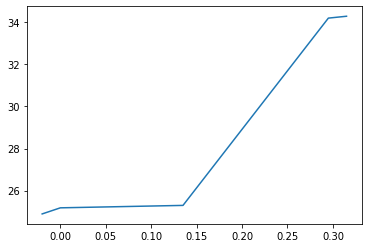

In [86]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2022-01-29 06:00', '2022-02-02 06:00')
first, last = index.dfinit()
columns = index.cols()
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]
q_stat, points = U_cls.q_U(U_val, indoor, outdoor)
plt.plot(points, q_stat[0])

In [136]:
test_materijal = Material()
test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
#test_materijal.new_material('izolacija', cond=0.04, rho=40, c=1030, l=0.16)
test_materijal.new_material('opreka', cond=0.77, rho=1967, c=835, l=0.38)
test_materijal.new_material('žbuka', cond=1, rho=1800, c=1000, l=0.02)
test_otpor = Resistance(test_materijal.layers, delta_x=0.005, delta_t=60)
R_mat, tau, R_bound, mesh = test_otpor.resistance_tau()

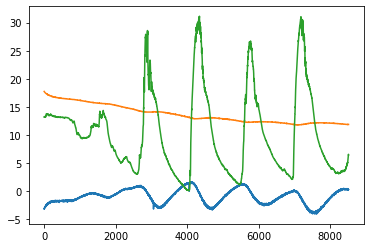

In [137]:
name = 'TRSYS01_Public-beton.dat'
index = RawData_index(name, '2021-10-22 12:00', '2021-10-28 09:55')
first, last = index.dfinit()
columns = index.cols()
series = RawData_series(name, first, last, columns)
vectors = series.ex_vect()
indoor = vectors[0]
outdoor = vectors[1]
hf = vectors[4]
plt.plot(hf)
plt.plot(indoor)
plt.plot(outdoor)

In [173]:
#outdoor_init = np.array([16 for i in range(60*60*3)])
#indoor_init = np.array([16 for i in range(60*60*3)])
initial = np.array([16 for i in range(len(tau))])
#res_init = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor_init, outdoor_init)

In [174]:
#initial = res_init[-1][1:len(res_init[-1])-1]
#results_beton = test_otpor.solve_he(R_mat, tau, R_bound, initial, indoor, outdoor)

In [175]:
q_calc_beton, Q_calc_beton = test_otpor.q_Q(results_beton, mesh)


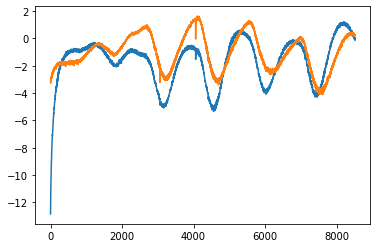

In [176]:
plt.plot(q_calc_beton)
plt.plot(hf)